# Kaggle: Kobe Bryant Shot Selection (Model)

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

To avoid leakage, your method should only train on events that occurred prior to the shot for which you are predicting! Since this is a playground competition with public answers, it's up to you to abide by this rule.

https://www.kaggle.com/c/kobe-bryant-shot-selection/data

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style; style.use('ggplot')

In [20]:
# load data (already sorted by shot_id, order is necessary for submission)
data = pd.read_csv('data.csv')
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


## Plan:
In visualization notebook:
- separate train and test data
    - use all labeled data for train, all unlabeled for test
    - remember to perform all preprocessing on BOTH train and test data together
- explore train data
    - determine trends
    - make visualizations

In model notebook:
- determine relevant features
- preprocess relevant features
    - BOTH train and test together
- determine model type
    - test various models using cross validation
        - break train set into train and validation sets
    - record best model
- make predictions on test set using best model

In [21]:
list(data)

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id']

## Features to save:
- action_type/combined_shot_type: type of shot
    - yes, only use one
    - one-hot encode from string
- game_event_id/game_id: specific game when shot was taken
    - maybe, only use game_id
        - 1558 values: corresponds to total number of games Kobe played
    - one hot encode from int
- lat/lon: lattitude and longitude
    - maybe -- is this where in the country the game occured?
- loc_x/loc_y: x and y coordinates on court where shot was taken
    - yes
- minutes_remaining
    - yes
    - no preprocessing?
- period: quarter (or overtime, up to triple overtime (7))
    - yes
    - one hot encode from int
- playoffs
    - yes
    - already one hot encoded
- season: date range in years
    - yes
    - one-hot encode from string
- seconds_remaining
    - maybe -- range from 0-59, what is this referring to?
- shot_distance: from basket
    - yes
    - no preprocessing
- shot_type: 2pt or 3pt
    - yes
    - one hot encode
- shot_zone_area: left, right, center
    - yes
    - one hot encode
- shot_zone_basic: paint, mid-range, etc.
    - yes
    - one hot encode
- shot_zone_range
    - maybe (watch for double counting with distance)
    - one hot encode
- team_id/team_name: lakers (single value)
    - no
- game_date: year, month, day
    - no
- matchup/opponent
    - yes
    - matchup: opponent AND home (vs) or away (@)
    - opponent: just opponent
- shot_id: unique value for every shot
    - no

## Label:
- shot_made_flag is the label column

## Preprocessing
Remember to apply preprocessing on ALL of the data.

In [22]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()
scaler = StandardScaler()

In [23]:
# combined_shot_type: one-hot encode from string
combined_shot_type = one_hot_encoder.fit_transform(data.combined_shot_type.values.reshape(-1, 1)).toarray()

In [24]:
# period: one-hot encode from int
period = one_hot_encoder.fit_transform(data.period.values.reshape(-1, 1)).toarray()

In [25]:
# season: one-hot encode from string
season = one_hot_encoder.fit_transform(data.season.values.reshape(-1, 1)).toarray()

In [26]:
# shot zone distance: scale
shot_distance = scaler.fit_transform(data.shot_distance.values.reshape(-1, 1).astype(np.float64))

In [27]:
# shot_type: one-hot encode from string
shot_type = one_hot_encoder.fit_transform(data.shot_type.values.reshape(-1, 1)).toarray()

In [28]:
# shot_zone_area: one-hot encode from string
shot_zone_area = one_hot_encoder.fit_transform(data.shot_zone_area.values.reshape(-1, 1)).toarray()

In [29]:
# shot_zone_basic: one-hot encode from string
shot_zone_basic = one_hot_encoder.fit_transform(data.shot_zone_basic.values.reshape(-1, 1)).toarray()

In [30]:
# put all relevant features together
X = np.hstack((combined_shot_type,
               period,
               data.playoffs.values.reshape(-1, 1),
               season,
               shot_distance,
               shot_type,
               shot_zone_area,
               shot_zone_basic))

# store labels
y = data[np.isnan(data.shot_made_flag) == False].shot_made_flag.values

In [31]:
X.shape, y.shape

((30697, 50), (25697,))

In [32]:
X[:5]

array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.48672341,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.

## Train/Validation/Test Split

In [33]:
# train/test split
X_train = X[np.isnan(data.shot_made_flag) == False]
y_train = y
X_test = X[np.isnan(data.shot_made_flag) == True]

In [34]:
# save train set before splitting into train and validation (to train final model)
old_X_train = X_train
old_y_train = y_train

# further split train into train/validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    shuffle=True)

In [35]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((20557, 50), (5140, 50), (20557,), (5140,))

## PCA for feature visualization

In [36]:
# use PCA to reduce feature dimension to 2 in order to visualize
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_red = pca.fit_transform(old_X_train)

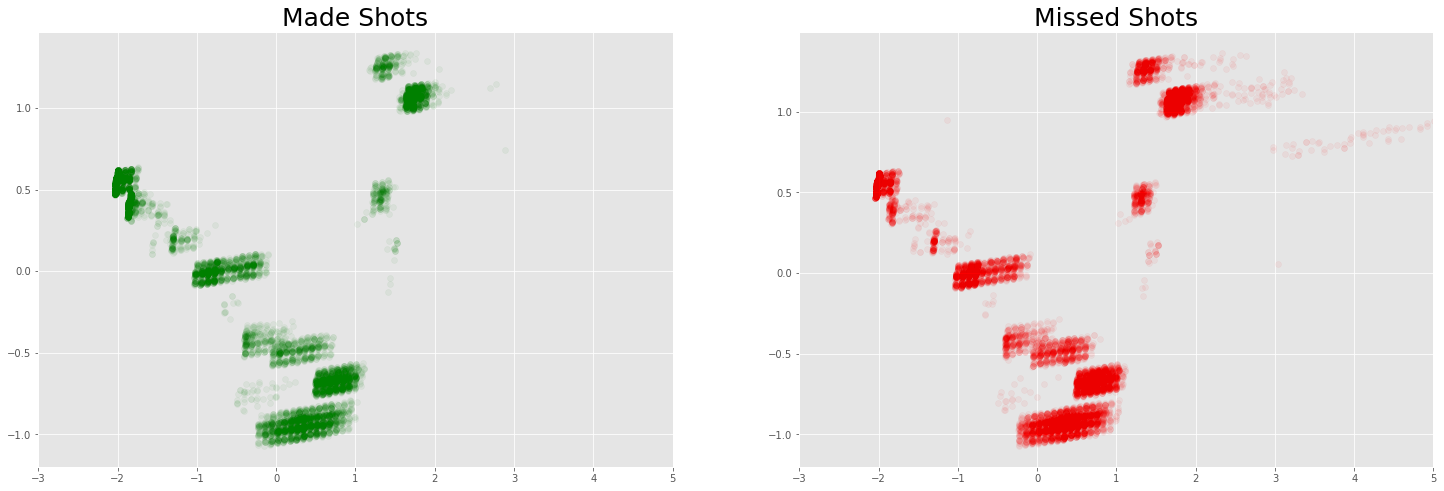

In [58]:
# split reduced data into made and missed sets
made = X_red[old_y_train == 1]
missed = X_red[old_y_train == 0]

# setup side-by-side plots
figure, (made_ax, miss_ax) = plt.subplots(1, 2)
figure.set_size_inches(25, 8)

made_ax.scatter(made[:, 0], made[:, 1], alpha=0.05, color='green')
made_ax.set_title('Made Shots', fontsize=25)
made_ax.set_xlim(-3, 5)

miss_ax.scatter(missed[:, 0], missed[:, 1], alpha=0.05, color='red')
miss_ax.set_title('Missed Shots', fontsize=25)
miss_ax.set_xlim(-3, 5);

## Models

In [59]:
# performance if predicting every shot as a miss, 50% chance of every shot going in
from sklearn.metrics import accuracy_score, log_loss
accuracy_score(y_val, np.zeros(y_val.shape)), log_loss(y_val, np.full((y_val.shape), 0.5))

(0.5531128404669261, 0.6931471805599453)

If we predict every shot as a miss, we get 54.7% accuracy

If we predict that every shot has a 50% chance of going in, we get a log loss of 0.69

In [ ]:
# knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# performance
accuracy_score(y_val, knn.predict(X_val)), log_loss(y_val, knn.predict_proba(X_val))

In [60]:
# logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1, solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

# performance
accuracy_score(y_val, log_reg.predict(X_val)), log_loss(y_val, log_reg.predict_proba(X_val))

(0.6147859922178989, 0.648196076913389)

In [ ]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# performance
accuracy_score(y_val, tree.predict(X_val)), log_loss(y_val, tree.predict_proba(X_val))

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500)
forest.fit(X_train, y_train)

# performance
accuracy_score(y_val, forest.predict(X_val)), log_loss(y_val, forest.predict_proba(X_val))

In [ ]:
# svm
from sklearn.svm import SVC
svm = SVC(kernel='rbf', gamma='auto', probability=True)
svm.fit(X_train, y_train)

# performance
accuracy_score(y_val, svm.predict(X_val)), log_loss(y_val, svm.predict_proba(X_val))

In [ ]:
# neural net
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(25, 10, 5), max_iter=1000)
nn.fit(X_train, y_train)

# performance
accuracy_score(y_val, nn.predict(X_val)), log_loss(y_val, nn.predict_proba(X_val))

Surprisingly, logistic regression returns the best results on this dataset.

Our logistic regression model outperforms a classifier that simply guesses 'all misses' or '50/50 for every shot'.

But...it's not that much better!

Note that a classifier like a SVM returns a slightly higher accuracy. However, the Kaggle competition is not scored on accuracy -- it's scored on log loss. Logistic regression returns the lowest log loss, making it the best model thus far.

## Predictions

In [61]:
# train logistic regression on all data, then make predictions
log_reg.fit(old_X_train, old_y_train)
predictions = log_reg.predict_proba(X_test)

In [62]:
predictions[:10, :]

array([[0.58915135, 0.41084865],
       [0.56773341, 0.43226659],
       [0.41191287, 0.58808713],
       [0.42390449, 0.57609551],
       [0.58567585, 0.41432415],
       [0.56325008, 0.43674992],
       [0.41539102, 0.58460898],
       [0.41539102, 0.58460898],
       [0.41191287, 0.58808713],
       [0.58212952, 0.41787048]])

In [63]:
test_df = data[np.isnan(data.shot_made_flag)]
test_df.iloc[:10, :]

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
7,Jump Shot,Jump Shot,254,20000012,34.0163,1,28,-118.2688,8,3,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,8
16,Driving Layup Shot,Layup,100,20000019,34.0443,0,0,-118.2698,0,1,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-11-01,LAL vs. UTA,UTA,17
19,Driving Layup Shot,Layup,249,20000019,34.0443,0,0,-118.2698,10,3,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-11-01,LAL vs. UTA,UTA,20
32,Jump Shot,Jump Shot,4,20000047,33.9683,163,76,-118.1068,11,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-11-04,LAL @ VAN,VAN,33
33,Jump Shot,Jump Shot,8,20000047,33.8503,70,194,-118.1998,10,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-11-04,LAL @ VAN,VAN,34
34,Layup Shot,Layup,26,20000047,34.0253,1,19,-118.2688,7,1,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-11-04,LAL @ VAN,VAN,35
35,Layup Shot,Layup,37,20000047,34.0293,-12,15,-118.2818,5,1,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-11-04,LAL @ VAN,VAN,36
36,Reverse Layup Shot,Layup,53,20000047,34.0403,1,4,-118.2688,4,1,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-11-04,LAL @ VAN,VAN,37
37,Jump Shot,Jump Shot,165,20000047,33.9283,-117,116,-118.3868,5,2,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-11-04,LAL @ VAN,VAN,38


Based on above two cells, predictions in form [P(miss), P(make)], same as [P(0), P(1)]

Only save P(make)? Yes! The competition wants us to submit our probability predictions that a shot was made.

In [ ]:
# setup np array for submission
submission = np.hstack((test_df.shot_id.values.reshape(-1, 1).astype(object), 
                        predictions[:, -1].reshape(-1, 1).astype(object)))

submission = np.vstack((np.array(['shot_id', 'shot_made_flag']),
                       submission))

In [ ]:
submission

In [ ]:
""" ONLY RUN WHEN READY TO WRITE TO FILE """
# write predictions and indices to csv
np.savetxt('log_reg_kobe_predictions2.csv', 
           submission, 
           delimiter=',', 
           fmt='%s')

## Results
Our logistic regression model resulted in a competition log loss of 0.64850. This isn't that much better than guessing '50/50 for every shot'.

The very best score on the leaderboard is 0.56528! This isn't very good either!

It's important to understand this dataset in order to see why it's difficult to create a good model. The dataset is messy, in a sense. By this, I mean that two very similar data points often have opposite labels. 

Think about where this data is coming from: these are Kobe Bryant's shots in basketball games. If you've ever watched Kobe play (or if you've ever seen a basketball game, for that matter) you know that players can be inconsistent. On one play, Kobe may make a 3-pointer from the top of the circle. On another play, he may take the exact same shot -- and miss!

Because of the player inconsistencies, it's difficult to accurately predict when a shot will be made using standard machine learning classifiers. This is probably the reason why the competition is scored on log loss rather than accuracy.